In [1]:
import numpy as np, plottools as pl, cmb, prjlib, tools_qrec, tools_y, binning as bn, curvedsky as cs, basic
from scipy.signal import savgol_filter
from matplotlib.pyplot import *
from scipy.interpolate import interp1d

In [2]:
def obscls(cl,sig,theta,alpha,lmax,ac2rad=np.pi/10800.,Tcmb=2.726e6):
    cl[2,:] *= alpha # delensing 
    l   = np.linspace(0,lmax,lmax+1)
    nl  = np.zeros((4,lmax+1))
    nl[0,:] = (sig*ac2rad/Tcmb)**2 * np.exp(l*(l+1)*(theta*ac2rad)**2/8./np.log(2.))
    nl[1,:] = 2*nl[0,:]
    nl[2,:] = 2*nl[0,:]
    ocl = cl + nl
    ocl[0,3001:] = 1e30 # Tlmax = 3000
    return ocl, nl

In [3]:
def covariance(cb,num):
    cov = np.zeros((2*num,2*num))
    for b in range(2*num):
        cov[b,b] = cb[b]**2
    return cov

In [4]:
lmax  = 4096       # maximum multipole of output normalization
rlmin, rlmax = 100, lmax  # reconstruction multipole range
olmax = 2048
L = np.linspace(0,olmax,olmax+1)
#l = np.linspace(0,lmax,lmax+1)
gnu = cmb.T2y(150.)

In [5]:
aobj = prjlib.init_analysis(fltr='cinv')
qtau, __, __, qtbh, qtBH = tools_qrec.init_quad(aobj.ids,aobj.stag,rlmin=100,rlmax=2048)
cy = tools_y.init_compy(aobj.ids,ascale=1.)

In [6]:
lb, incl = (np.loadtxt('../data/plk/input/forecast_tt_TH_R5.0_a0.0.dat',usecols=(0,1))).T
ctt = np.concatenate((np.array([0.,0.]),interp1d(lb, incl )(L[2:])))
cty = 1.7e-6*ctt

In [7]:
yy = {}
yy['plk'] = savgol_filter( (np.loadtxt(cy.fclyy)).T[1], 51, 3)
bl, y0 = np.loadtxt('../data/other/yy.dat',unpack=True)
yy['pico'] = interp1d(bl, savgol_filter( y0, 15, 13) )(L[2:]) * 2*np.pi/(L[2:]**2+L[2:]+.001)/2.72e6**2/gnu**2
yy['pico'] = np.concatenate((np.array([1e30,1e30]),yy['pico']))

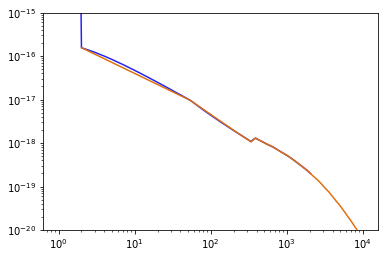

In [8]:
ylim(1e-20,1e-15)
yscale('log')
xscale('log')
plot(L,yy['pico'])
plot(bl,y0*2*np.pi/(bl**2+bl+.001)/2.72e6**2/gnu**2)

In [9]:
exps = ['S4W','S4D','HD']
sigma = {'S4W':1.,'S4D':.3,'HD':.5} # uK-ac in temperature
alpha = {'S4W':.2,'S4D':.07,'HD':.1}
theta = {'S4W':2.,'S4D':2.,'HD':.2}
fsky = {'S4W':.4,'S4D':.04,'HD':.5}
labs = ['S4-Wide','S4-Deep','HD']
colors = ['b','g','r']

In [10]:
lcl = cmb.read_camb_cls(aobj.simcl,ftype='lens',output='array')[:,:lmax+1]
ucl = cmb.read_camb_cls(aobj.simul,ftype='scal',output='array')[:,:lmax+1]
ocl = {exp: obscls(lcl,sigma[exp],theta[exp],alpha[exp],lmax)[0] for exp in exps}
ncl = {exp: obscls(lcl,sigma[exp],theta[exp],alpha[exp],lmax)[1] for exp in exps}
#for i in range(3):  ncl['S4D'][i,:] = ncl['S4D'][i,:]*ncl['S4W'][i,:] / ( ncl['S4W'][i,:] + ncl['S4D'][i,:] )
#ocl['S4D'] = lcl + ncl['S4D']
#ocl['S4D'][0,3001:] = 1e30 # Tlmax = 3000

In [11]:
# check delensing efficiency alpha
'''
OCL = {exp: obscls(lcl,sigma[exp],theta[exp],1.,lmax)[0] for exp in ['HD']}
dlmin, dlmax = 2, 4096
WE = np.ones((dlmax+1))
bb = basic.delens.lensingbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1])
rbb = {}
for exp in ['HD']:
    Ag, __ = cs.norm_lens.qeb_iter(lmax,rlmax,rlmin,rlmax,rlmin,rlmax,lcl[1,:],OCL[exp][1,:],OCL[exp][2,:],ucl[3,:],iter=10)
    Wp = ucl[3,:]/(ucl[3,:]+Ag)
    rbb[exp] = basic.delens.resbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1], WE, Wp[:dlmax+1])
ylim(0,1)
for exp in ['HD']:
    plot(rbb[exp]/bb)
    plot((OCL[exp][2,:]-bb+rbb[exp])/bb)
'''

"\nOCL = {exp: obscls(lcl,sigma[exp],theta[exp],1.,lmax)[0] for exp in ['HD']}\ndlmin, dlmax = 2, 4096\nWE = np.ones((dlmax+1))\nbb = basic.delens.lensingbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1])\nrbb = {}\nfor exp in ['HD']:\n    Ag, __ = cs.norm_lens.qeb_iter(lmax,rlmax,rlmin,rlmax,rlmin,rlmax,lcl[1,:],OCL[exp][1,:],OCL[exp][2,:],ucl[3,:],iter=10)\n    Wp = ucl[3,:]/(ucl[3,:]+Ag)\n    rbb[exp] = basic.delens.resbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1], WE, Wp[:dlmax+1])\nylim(0,1)\nfor exp in ['HD']:\n    plot(rbb[exp]/bb)\n    plot((OCL[exp][2,:]-bb+rbb[exp])/bb)\n"

In [23]:
AlTT = {exp: cs.norm_quad.qtt('amp',olmax,rlmin,rlmax,lcl[0,:],ocl[exp][0,:])[0] for exp in exps}
AlEB = {exp: cs.norm_quad.qeb('amp',olmax,rlmin,rlmax,lcl[1,:],ocl[exp][1,:],ocl[exp][2,:])[0] for exp in exps}
#AlEB = {exp: cs.norm_tau.qeb(olmax,rlmin,rlmax,lcl[1,:],ocl[exp][1,:],ocl[exp][2,:]-lcl[2,:]+rbb[exp]) for exp in exps}

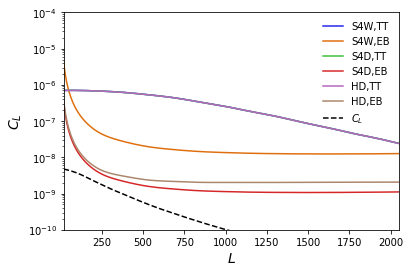

In [25]:
pl.plot_1dstyle(ylog=True,ymin=1e-10,ymax=1e-4)
for exp in exps:
    plot(L,AlTT[exp],label=exp+',TT')
    plot(L,AlEB[exp],label=exp+',EB')
plot(L,ctt,color='k',ls='--',label=r'$C_L$')
legend()

In [ ]:
# cross correlation coefficient
pl.plot_1dstyle(ylog=True,ymin=1e-5,ymax=1)
for exp in exps:
    plot(L,2*np.pi*1e-11/(L**2+L+1e-30)/(np.sqrt(AlEB[exp]*yy['pico'])+1e-30))

In [ ]:
mb = bn.multipole_binning(10,lmin=1,lmax=2048)

In [ ]:
cttb = bn.binning(ctt*L*(L+1)/2/np.pi,mb)
ctyb = bn.binning(cty*L*(L+1)/2/np.pi,mb)

In [ ]:
ttTT = {exp: bn.binning_opt_weight( AlTT[exp]/np.sqrt(fsky[exp]*(qtau.l+.5)), mb ) for exp in exps}
ttEB = {exp: bn.binning_opt_weight( AlEB[exp]/np.sqrt(fsky[exp]*(qtau.l+.5)), mb ) for exp in exps}

In [ ]:
pl.plot_1dstyle(ylab=r'$L(L+1)C^{\delta\tau\delta\tau}_L/2\pi$',usetex=True,ymin=5e-6,ymax=5e-5,ylog=True)
s = mb.bc*(mb.bc+1)/2./np.pi
for i, (exp,lab) in enumerate(zip(exps,labs)):
    #plot(mb.bc,ttTT[exp],label=exp+',TT')
    errorbar(mb.bc+10*i-10,cttb,yerr=s*ttEB[exp],fmt='o',label=lab)
plot(L,L*(L+1)*ctt/2/np.pi,color='k',ls='--')
legend()

In [ ]:
plot(ttEB['S4W']/ttEB['S4D'])

In [ ]:
#tyTT = {exp: bn.binning_opt_weight( np.sqrt(AlTT[exp]*yy[expy])/np.sqrt(2*fsky[exp]*(qtau.l+.5)), mb ) for exp in exps}
expys = ['plk','pico']
tyEB = {expy : {exp: bn.binning_opt_weight( np.sqrt(AlEB[exp]*yy[expy])/np.sqrt(2*fsky[exp]*(qtau.l+.5)), mb ) for exp in exps} for expy in expys }

In [ ]:
pl.plot_1dstyle(ylab=r'$L(L+1)C^{\delta\tau y}_L/2\pi$',usetex=True,ymin=5e-12,ymax=1e-10,ylog=True)
s = mb.bc*(mb.bc+1)/2./np.pi
for j, (exp,lab,c) in enumerate(zip(exps,labs,colors)):
    errorbar(mb.bc+20*j-20,ctyb,yerr=s*tyEB['pico'][exp],fmt='o',label='PICO x '+lab,color=c)
plot(L,cty*L*(L+1)/2/np.pi,color='k',ls='--')
legend()
savefig('fig_forecast_ty.pdf')

In [ ]:
#cbTT = {exp: np.concatenate((ttTT[exp],tyTT[exp])) for exp in exps}
cbEB = {expy: {exp: np.concatenate((ttEB[exp],tyEB[expy][exp])) for exp in exps} for expy in expys}

In [ ]:
#covTT = {exp: covariance(cbTT[exp],mb.n) for exp in exps}
covEB = {expy: {exp: covariance(cbEB[expy][exp],mb.n) for exp in exps} for expy in expys}

In [ ]:
#print(covEB['plk']['S4W'].diagonal())
#cov0 = np.loadtxt('../v3.1/covariance_dr2_smica_Lmask_nilc_G60_bh-lens-src.dat')
#print(cov0.diagonal())

In [ ]:
#for expy in expys:
#    for exp in exps:
#        np.savetxt('../v4.3/covariance_'+exp+'_y-'+expy+'.dat',covEB[expy][exp])